## HW4

### Task 1:
#### Part 1 (35 points): Implement your RNN either using an existing framework OR you can implement your own RNN cell structure. In either case, describe the structure of your RNN and the activation functions you are using for each time step and in the output layer. Define a metric you will use to measure the performance of your model (NOTE: Performance should be measured both for the validation set and the test set).

In [39]:
%matplotlib inline
import numpy as np
import pandas as pd
# import theano
# import theano.tensor as T
import keras 

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import image

from keras.datasets import imdb
from keras.datasets import mnist

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN



## IMDB sentiment classification task

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. 

IMDB provided a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. 

There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. 

reference: http://ai.stanford.edu/~amaas/data/sentiment/

Why RNN for sentiment classification? RNN models are mostly used in the fields of natural language processing, dealing with sequential data. In sentiment classification for IMDB dataset, we are dealing with sequential input for outputing either positive or negative predictions.

In [44]:
max_features = 20000
maxlen = 100  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

#Load data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

num_validation = 1000
X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]
X_train = X_train[:num_training]
y_train = y_train[:num_training]

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (24000, 100)
X_val shape: (1000, 100)
X_test shape: (25000, 100)


### RNN  
https://keras.io/api/layers/recurrent_layers/simple_rnn/

```python
keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, 
                                 kernel_initializer='glorot_uniform', 
                                 recurrent_initializer='orthogonal', 
                                 bias_initializer='zeros', 
                                 kernel_regularizer=None, 
                                 recurrent_regularizer=None, 
                                 bias_regularizer=None, 
                                 activity_regularizer=None, 
                                 kernel_constraint=None, recurrent_constraint=None, 
                                 bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)
```


<tr>
<td> <img src="./rnn-many-to-one-ltr.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./description-block-rnn-ltr.png" alt="Drawing" style="width: 250px;"/> </td>
</tr>


$a^{<t>}=g_{1}\left(W_{a a} a^{<t-1>}+W_{a x} x^{<t>}+b_{a}\right) \quad \text { and } y=g_{2}\left(W_{y a} a^{<t>}+b_{y}\right)$ where $W_{a x}, W_{a a}, W_{y a}, b_{a}, b_{y}$ are coefficients that are shared temporally and 
$g_1, g_2$ are activation functions. Actication functions here are tanh, where $$g(z)=\frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$$


<a href="https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks">https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks</a>



In [64]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(SimpleRNN(128))  
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(X_train, y_train, batch_size=batch_size, 
          epochs=5, validation_data=(X_val, y_val))



Epoch 1/5
750/750 [==============================] - 27s 36ms/step - loss: 0.5907 - val_loss: 0.5112
Epoch 2/5
750/750 [==============================] - 24s 32ms/step - loss: 0.4263 - val_loss: 0.6014
Epoch 3/5
750/750 [==============================] - 24s 32ms/step - loss: 0.3870 - val_loss: 0.5006
Epoch 4/5
750/750 [==============================] - 24s 32ms/step - loss: 0.3576 - val_loss: 0.5022
Epoch 5/5
750/750 [==============================] - 25s 34ms/step - loss: 0.2960 - val_loss: 0.5672


#### The metric we use for classification is accuracy, which is defined as the ratio of correct prediction over total predictions.

In [65]:
y_pred = model.predict(X_train)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_train, y_pred))
print('training accuracy:', acc)

y_pred = model.predict(X_val)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_val, y_pred))
print('val accuracy:', acc)

y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_test, y_pred))
# print('Test score:', score)
print('Test accuracy:', acc)

training accuracy: 0.9166666666666666
val accuracy: 0.761
Test accuracy: 0.77408


#### Part 2 (25 points): Update your network from part 1 with either an LSTM or a GRU based cell structure. Re-do the training and performance evaluation. What are the major differences you notice? Why do you think those differences exist between the 2 implementations?

### LSTM  
https://keras.io/api/layers/recurrent_layers/lstm/

<img src="./lstm-ltr.png" alt="Drawing" style="width: 250px;"/>
$$\Gamma=\sigma\left(W x^{<t>}+U a^{<t-1>}+b\right)$$ where $W,U,b$ are coefficients specific to the gate and $\sigma$ is the sigmoid function. 
$$\tilde{c}^{<t>} = \tanh \left(W_{c}\left[\Gamma_{r} \cdot a^{<t-1>}, x^{<t>}\right]+b_{c}\right)$$
$${c}^{<t>} = \Gamma_{u} \cdot \tilde{c}^{<t>}+\Gamma_{f} \cdot c^{<t-1>}$$
$${a}^{<t>} = \Gamma_{o} \cdot c^{<t>}$$

```python
keras.layers.recurrent.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
                            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
                            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
                            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                            dropout=0.0, recurrent_dropout=0.0)
```

In [55]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen)) 
model.add(LSTM(128))  
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(X_train, y_train, batch_size=batch_size, 
          epochs=5, validation_data=(X_val, y_val))

Train...
Epoch 1/5
750/750 [==============================] - 46s 61ms/step - loss: 0.4220 - val_loss: 0.3502
Epoch 2/5
750/750 [==============================] - 45s 61ms/step - loss: 0.2354 - val_loss: 0.3778
Epoch 3/5
750/750 [==============================] - 47s 62ms/step - loss: 0.1453 - val_loss: 0.4282
Epoch 4/5
750/750 [==============================] - 48s 64ms/step - loss: 0.0916 - val_loss: 0.5002
Epoch 5/5
782/782 [==============================] - 12s 15ms/step - loss: 0.6973


In [61]:
y_pred = model.predict(X_train)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_train, y_pred))
print('training accuracy:', acc)

y_pred = model.predict(X_val)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_val, y_pred))
print('val accuracy:', acc)

y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_test, y_pred))
# print('Test score:', score)
print('Test accuracy:', acc)

training accuracy: 0.9856666666666667
val accuracy: 0.822
Test accuracy: 0.82424


### GRU  
https://keras.io/api/layers/recurrent_layers/gru/
<img src="./gru-ltr.png" alt="Drawing" style="width: 250px;"/>
$$\tilde{c}^{<t>} = \tanh \left(W_{c}\left[\Gamma_{r} \cdot a^{<t-1>}, x^{<t>}\right]+b_{c}\right)$$
$${c}^{<t>} = \Gamma_{u} \cdot \tilde{c}^{<t>}+\left(1-\Gamma_{u}\right) \cdot c^{<t-1>}$$
$${a}^{<t>} = c^{<t>}$$

```python
keras.layers.recurrent.GRU(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
                           kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
                           bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, 
                           bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
                           recurrent_constraint=None, bias_constraint=None, 
                           dropout=0.0, recurrent_dropout=0.0)
```

In [62]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(GRU(128))  
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(X_train, y_train, batch_size=batch_size, 
          epochs=5, validation_data=(X_val, y_val))


Epoch 1/5
750/750 [==============================] - 42s 54ms/step - loss: 0.4581 - val_loss: 0.3784
Epoch 2/5
750/750 [==============================] - 41s 54ms/step - loss: 0.2468 - val_loss: 0.4013
Epoch 3/5
750/750 [==============================] - 42s 57ms/step - loss: 0.1414 - val_loss: 0.4122
Epoch 4/5
750/750 [==============================] - 42s 56ms/step - loss: 0.0735 - val_loss: 0.5356
Epoch 5/5
750/750 [==============================] - 42s 56ms/step - loss: 0.0388 - val_loss: 0.6831


In [63]:
y_pred = model.predict(X_train)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_train, y_pred))
print('training accuracy:', acc)

y_pred = model.predict(X_val)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_val, y_pred))
print('val accuracy:', acc)

y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.flatten()
acc = np.mean(np.equal(y_test, y_pred))
# print('Test score:', score)
print('Test accuracy:', acc)

training accuracy: 0.9958333333333333
val accuracy: 0.833
Test accuracy: 0.83404


#### For LSTM and GRU, we clearly see a faster convergence for the training loss and improved prediction accuracy for test and validation dataset.

### Task 2:
In this task, use any of the pre-trained word embeddings. The Wor2vec embedding link provided with the lecture notes can be useful to get started. Write your own code/function that uses these embeddings and outputs cosine similarity and a dissimilarity score for any 2 pair of words (read as user input). The dissimilarity score should be defined by you. You either can have your own idea of a dissimilarity score or refer to literature (cite the paper you used). In either case clearly describe how this score helps determine the dissimilarity between 2 words.

[nltk_data] Downloading package brown to /Users/ulysses/nltk_data...
[nltk_data]   Package brown is already up-to-date!


3 words similar to car
('truck', 0.7733270525932312)
('boat', 0.7584270238876343)
('wagon', 0.7152294516563416)



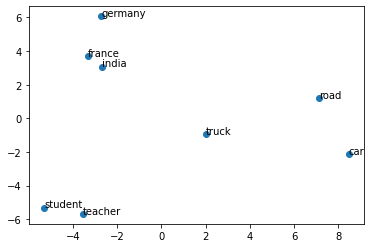

In [8]:
#Vanilla example for word2vec embedding
import string
import nltk
from nltk.corpus import brown
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
 
nltk.download("brown")
 
# Preprocessing data to lowercase all words and remove single punctuation words
document = brown.sents()
data = []
for sent in document:
    new_sent = []
    for word in sent:
        new_word = word.lower()
        if new_word[0] not in string.punctuation:
            new_sent.append(new_word)
    if len(new_sent) > 0:
        data.append(new_sent)
        
# Creating Word2Vec
model = Word2Vec(
    sentences = data,
    vector_size = 50,
    window = 10,
    epochs = 20,
)
 
# Finding most similar words
print("3 words similar to car")
words = model.wv.most_similar("car", topn=3)
for word in words:
    print(word)
print()
 
#Visualizing data
words = ["france", "germany", "india", "truck", "car","road", "teacher", "student"]
 
X = model.wv[words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
 
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

Cosine similarity of two n-dimensional vectors $\mathbf{w_1}$ and $\mathbf{w_2}$ is defined as:
$$\cos(\mathbf{w_1},\mathbf{w_2})=\frac{\mathbf{w_1} \cdot \mathbf{w_2}}{\|\mathbf{w_1}\|\|\mathbf{w_2}\|}=\frac{\sum_{i=1}^{n} {\mathbf{w_{1_i}}} {\mathbf{w_{2_i}}}}{\sqrt{\sum_{i=1}^{n} {{\mathbf{w_{1_i}}}^{2}}} \sqrt{\sum_{i=1}^{n} {\mathbf{w_{2_i}}}^{2}}}$$
<img src="./cosine-similarity.png" alt="Drawing" style="width: 250px;"/>\ 

In [10]:
# download pre-trained word2vec embeddings from gensim
# reference: https://radimrehurek.com/gensim/models/word2vec.html

import gensim
import gensim.downloader
 
google_news_vectors = gensim.downloader.load('word2vec-google-news-300')

In [32]:
# Finding words similar to BMW
print("5 similar words to BMW:")
words = google_news_vectors.most_similar("BMW", topn=5)
for word in words:
    print(word)
print()
 
# Finding words similar to Love
print("3 similar words to China:")
words = google_news_vectors.most_similar("China", topn=3)
for word in words:
    print(word)
print()
 
# Finding cosine similarity between fight and battle
cosine = google_news_vectors.similarity("fight", "battle")
print("Cosine similarity between fight and battle:", cosine)
print()
 
# Finding cosine similarity between fight and love
cosine = google_news_vectors.similarity("China", "book")
print("Cosine similarity between China and book:", cosine)

5 similar words to BMW:
('Audi', 0.7932199835777283)
('Mercedes_Benz', 0.7683466672897339)
('Porsche', 0.7272197604179382)
('Mercedes', 0.7078384160995483)
('Volkswagen', 0.6959410905838013)

3 similar words to China:
('Chinese', 0.7678080797195435)
('Beijing', 0.7648460865020752)
('Taiwan', 0.7081157565116882)

Cosine similarity between fight and battle: 0.7021284

Cosine similarity between China and book: 0.055054046


### dissimilarity measure
So I define my dissimilarity measure as $$\text {dissim}(\mathbf{w_1},\mathbf{w_2})=\left(\frac{1}{\cos(\mathbf{w_1},\mathbf{w_2})}-1\right)||\mathbf{w_1}-\mathbf{w_2}||_2^2$$ We know that cosine similarity values range between -1 and 1, where -1 is indicating two word vectors are on opposite direction and 1 is they pointing at the same direction, but we also need to take their euclidean distance into account because two word can be dissimilar even if their vectors are pointing into same direction. In this metric, the furthur this dissimilarity measure to zero, the more dissimilar the two words are. 0 means they are the same.

In [33]:
import numpy as np

# Finding dissimilarity between fight and battle
cosine = google_news_vectors.similarity("fight", "battle")
euclidean = np.linalg.norm(google_news_vectors['fight'] - google_news_vectors['battle'])
print("Dissimilarity between fight and battle:", euclidean/(cosine)-euclidean)
 
# Finding dissimilarity between fight and love
cosine = google_news_vectors.similarity("China", "book")
euclidean = np.linalg.norm(google_news_vectors['China'] - google_news_vectors['book'])
print("Dissimilarity between fight and love:", euclidean/(cosine)-euclidean)

Dissimilarity between fight and battle: 0.92319846
Dissimilarity between fight and love: 61.747517
